In [15]:
#!sudo pip install tqdm

In [16]:
#!sh download_data.sh

In [17]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialization

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effictively.

In [20]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [21]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [22]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [23]:
file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=1)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [24]:
file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=1)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


## Train detector

In [25]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')
    




Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [5/209] Loss: 67.2155, average_loss: 70.9981
Epoch [1/50], Iter [10/209] Loss: 47.8315, average_loss: 62.4808
Epoch [1/50], Iter [15/209] Loss: 25.7877, average_loss: 52.3723
Epoch [1/50], Iter [20/209] Loss: 19.5058, average_loss: 44.1059
Epoch [1/50], Iter [25/209] Loss: 13.0336, average_loss: 38.2586
Epoch [1/50], Iter [30/209] Loss: 9.6983, average_loss: 34.2120
Epoch [1/50], Iter [35/209] Loss: 9.6680, average_loss: 30.6841
Epoch [1/50], Iter [40/209] Loss: 6.8771, average_loss: 27.9143
Epoch [1/50], Iter [45/209] Loss: 6.7617, average_loss: 25.7489
Epoch [1/50], Iter [50/209] Loss: 10.2246, average_loss: 24.1042
Epoch [1/50], Iter [55/209] Loss: 7.3594, average_loss: 22.6484
Epoch [1/50], Iter [60/209] Loss: 7.8168, average_loss: 21.3239
Epoch [1/50], Iter [65/209] Loss: 9.7960, average_loss: 20.2466
Epoch [1/50], Iter [70/209] Loss: 5.7438, average_loss: 19.2530
Epoch [1/50], Iter [75/209] Loss: 6.914

Epoch [4/50], Iter [5/209] Loss: 2.9256, average_loss: 3.8211
Epoch [4/50], Iter [10/209] Loss: 3.9854, average_loss: 3.7124
Epoch [4/50], Iter [15/209] Loss: 5.1942, average_loss: 4.0564
Epoch [4/50], Iter [20/209] Loss: 3.1558, average_loss: 3.9536
Epoch [4/50], Iter [25/209] Loss: 4.1251, average_loss: 3.9167
Epoch [4/50], Iter [30/209] Loss: 3.4701, average_loss: 3.8944
Epoch [4/50], Iter [35/209] Loss: 3.3816, average_loss: 3.9495
Epoch [4/50], Iter [40/209] Loss: 4.2888, average_loss: 3.9879
Epoch [4/50], Iter [45/209] Loss: 4.0315, average_loss: 3.9800
Epoch [4/50], Iter [50/209] Loss: 3.5850, average_loss: 3.9616
Epoch [4/50], Iter [55/209] Loss: 4.1171, average_loss: 3.9840
Epoch [4/50], Iter [60/209] Loss: 5.9520, average_loss: 4.0433
Epoch [4/50], Iter [65/209] Loss: 3.5985, average_loss: 4.0302
Epoch [4/50], Iter [70/209] Loss: 3.1343, average_loss: 4.0662
Epoch [4/50], Iter [75/209] Loss: 4.9873, average_loss: 4.0894
Epoch [4/50], Iter [80/209] Loss: 3.0223, average_loss: 

Epoch [7/50], Iter [15/209] Loss: 2.8131, average_loss: 3.2867
Epoch [7/50], Iter [20/209] Loss: 3.1884, average_loss: 3.3771
Epoch [7/50], Iter [25/209] Loss: 4.8906, average_loss: 3.5435
Epoch [7/50], Iter [30/209] Loss: 3.8812, average_loss: 3.4990
Epoch [7/50], Iter [35/209] Loss: 2.9758, average_loss: 3.4898
Epoch [7/50], Iter [40/209] Loss: 2.7845, average_loss: 3.4730
Epoch [7/50], Iter [45/209] Loss: 2.8341, average_loss: 3.4504
Epoch [7/50], Iter [50/209] Loss: 3.2725, average_loss: 3.4305
Epoch [7/50], Iter [55/209] Loss: 3.2172, average_loss: 3.4263
Epoch [7/50], Iter [60/209] Loss: 2.1739, average_loss: 3.4521
Epoch [7/50], Iter [65/209] Loss: 3.7462, average_loss: 3.5134
Epoch [7/50], Iter [70/209] Loss: 3.2440, average_loss: 3.4941
Epoch [7/50], Iter [75/209] Loss: 3.0149, average_loss: 3.4983
Epoch [7/50], Iter [80/209] Loss: 3.8867, average_loss: 3.4953
Epoch [7/50], Iter [85/209] Loss: 4.1400, average_loss: 3.5219
Epoch [7/50], Iter [90/209] Loss: 3.1964, average_loss:

Epoch [10/50], Iter [25/209] Loss: 3.3316, average_loss: 3.1553
Epoch [10/50], Iter [30/209] Loss: 3.5169, average_loss: 3.2054
Epoch [10/50], Iter [35/209] Loss: 3.1507, average_loss: 3.2052
Epoch [10/50], Iter [40/209] Loss: 3.0455, average_loss: 3.2154
Epoch [10/50], Iter [45/209] Loss: 2.9561, average_loss: 3.1634
Epoch [10/50], Iter [50/209] Loss: 3.6855, average_loss: 3.1585
Epoch [10/50], Iter [55/209] Loss: 2.4322, average_loss: 3.1246
Epoch [10/50], Iter [60/209] Loss: 2.8076, average_loss: 3.1063
Epoch [10/50], Iter [65/209] Loss: 3.0912, average_loss: 3.1044
Epoch [10/50], Iter [70/209] Loss: 2.5360, average_loss: 3.0825
Epoch [10/50], Iter [75/209] Loss: 2.4581, average_loss: 3.0666
Epoch [10/50], Iter [80/209] Loss: 2.8664, average_loss: 3.0685
Epoch [10/50], Iter [85/209] Loss: 2.7829, average_loss: 3.0677
Epoch [10/50], Iter [90/209] Loss: 3.1125, average_loss: 3.0789
Epoch [10/50], Iter [95/209] Loss: 3.3736, average_loss: 3.0868
Epoch [10/50], Iter [100/209] Loss: 2.72

Epoch [13/50], Iter [25/209] Loss: 2.6508, average_loss: 2.8165
Epoch [13/50], Iter [30/209] Loss: 1.8319, average_loss: 2.7947
Epoch [13/50], Iter [35/209] Loss: 2.8845, average_loss: 2.8497
Epoch [13/50], Iter [40/209] Loss: 2.9478, average_loss: 2.8377
Epoch [13/50], Iter [45/209] Loss: 2.5697, average_loss: 2.8076
Epoch [13/50], Iter [50/209] Loss: 2.6103, average_loss: 2.8284
Epoch [13/50], Iter [55/209] Loss: 2.6000, average_loss: 2.8110
Epoch [13/50], Iter [60/209] Loss: 3.1527, average_loss: 2.8314
Epoch [13/50], Iter [65/209] Loss: 2.3943, average_loss: 2.8469
Epoch [13/50], Iter [70/209] Loss: 2.2074, average_loss: 2.8429
Epoch [13/50], Iter [75/209] Loss: 3.1378, average_loss: 2.8347
Epoch [13/50], Iter [80/209] Loss: 3.1432, average_loss: 2.8341
Epoch [13/50], Iter [85/209] Loss: 3.0858, average_loss: 2.8702
Epoch [13/50], Iter [90/209] Loss: 3.0274, average_loss: 2.8789
Epoch [13/50], Iter [95/209] Loss: 3.5664, average_loss: 2.8875
Epoch [13/50], Iter [100/209] Loss: 3.49

Epoch [16/50], Iter [25/209] Loss: 3.0734, average_loss: 2.6821
Epoch [16/50], Iter [30/209] Loss: 2.8742, average_loss: 2.7389
Epoch [16/50], Iter [35/209] Loss: 2.2711, average_loss: 2.6833
Epoch [16/50], Iter [40/209] Loss: 2.8359, average_loss: 2.7201
Epoch [16/50], Iter [45/209] Loss: 2.2382, average_loss: 2.6853
Epoch [16/50], Iter [50/209] Loss: 2.7864, average_loss: 2.6551
Epoch [16/50], Iter [55/209] Loss: 3.3577, average_loss: 2.6742
Epoch [16/50], Iter [60/209] Loss: 3.2871, average_loss: 2.6991
Epoch [16/50], Iter [65/209] Loss: 2.4207, average_loss: 2.7036
Epoch [16/50], Iter [70/209] Loss: 2.9670, average_loss: 2.6953
Epoch [16/50], Iter [75/209] Loss: 2.1974, average_loss: 2.6938
Epoch [16/50], Iter [80/209] Loss: 2.9918, average_loss: 2.6755
Epoch [16/50], Iter [85/209] Loss: 2.7775, average_loss: 2.6669
Epoch [16/50], Iter [90/209] Loss: 2.1525, average_loss: 2.6549
Epoch [16/50], Iter [95/209] Loss: 1.7899, average_loss: 2.6485
Epoch [16/50], Iter [100/209] Loss: 2.78

Epoch [19/50], Iter [30/209] Loss: 2.3015, average_loss: 2.5128
Epoch [19/50], Iter [35/209] Loss: 2.7340, average_loss: 2.5052
Epoch [19/50], Iter [40/209] Loss: 2.3589, average_loss: 2.5373
Epoch [19/50], Iter [45/209] Loss: 2.3795, average_loss: 2.5555
Epoch [19/50], Iter [50/209] Loss: 2.4027, average_loss: 2.5627
Epoch [19/50], Iter [55/209] Loss: 2.2143, average_loss: 2.5861
Epoch [19/50], Iter [60/209] Loss: 2.4848, average_loss: 2.5731
Epoch [19/50], Iter [65/209] Loss: 3.0881, average_loss: 2.5738
Epoch [19/50], Iter [70/209] Loss: 1.7512, average_loss: 2.5766
Epoch [19/50], Iter [75/209] Loss: 2.8833, average_loss: 2.5590
Epoch [19/50], Iter [80/209] Loss: 2.5866, average_loss: 2.5460
Epoch [19/50], Iter [85/209] Loss: 3.2650, average_loss: 2.5581
Epoch [19/50], Iter [90/209] Loss: 2.3028, average_loss: 2.5543
Epoch [19/50], Iter [95/209] Loss: 2.7387, average_loss: 2.5574
Epoch [19/50], Iter [100/209] Loss: 3.7091, average_loss: 2.5688
Epoch [19/50], Iter [105/209] Loss: 2.4

Epoch [22/50], Iter [35/209] Loss: 2.4733, average_loss: 2.5117
Epoch [22/50], Iter [40/209] Loss: 2.5496, average_loss: 2.5226
Epoch [22/50], Iter [45/209] Loss: 2.8737, average_loss: 2.5440
Epoch [22/50], Iter [50/209] Loss: 2.3283, average_loss: 2.5205
Epoch [22/50], Iter [55/209] Loss: 2.0374, average_loss: 2.5125
Epoch [22/50], Iter [60/209] Loss: 1.8350, average_loss: 2.4936
Epoch [22/50], Iter [65/209] Loss: 2.0663, average_loss: 2.4710
Epoch [22/50], Iter [70/209] Loss: 2.6308, average_loss: 2.4757
Epoch [22/50], Iter [75/209] Loss: 2.4046, average_loss: 2.4594
Epoch [22/50], Iter [80/209] Loss: 3.5463, average_loss: 2.4713
Epoch [22/50], Iter [85/209] Loss: 2.0162, average_loss: 2.4553
Epoch [22/50], Iter [90/209] Loss: 2.9149, average_loss: 2.4514
Epoch [22/50], Iter [95/209] Loss: 2.8394, average_loss: 2.4533
Epoch [22/50], Iter [100/209] Loss: 3.1709, average_loss: 2.4533
Epoch [22/50], Iter [105/209] Loss: 2.6559, average_loss: 2.4539
Epoch [22/50], Iter [110/209] Loss: 2.

Epoch [25/50], Iter [40/209] Loss: 2.6483, average_loss: 2.4077
Epoch [25/50], Iter [45/209] Loss: 1.9101, average_loss: 2.3940
Epoch [25/50], Iter [50/209] Loss: 3.0438, average_loss: 2.4032
Epoch [25/50], Iter [55/209] Loss: 2.2006, average_loss: 2.4151
Epoch [25/50], Iter [60/209] Loss: 2.3852, average_loss: 2.4058
Epoch [25/50], Iter [65/209] Loss: 1.8788, average_loss: 2.3854
Epoch [25/50], Iter [70/209] Loss: 2.2790, average_loss: 2.3757
Epoch [25/50], Iter [75/209] Loss: 1.7795, average_loss: 2.3801
Epoch [25/50], Iter [80/209] Loss: 1.9406, average_loss: 2.3586
Epoch [25/50], Iter [85/209] Loss: 2.5346, average_loss: 2.3763
Epoch [25/50], Iter [90/209] Loss: 1.8053, average_loss: 2.3745
Epoch [25/50], Iter [95/209] Loss: 1.7580, average_loss: 2.3691
Epoch [25/50], Iter [100/209] Loss: 2.4630, average_loss: 2.3566
Epoch [25/50], Iter [105/209] Loss: 1.9513, average_loss: 2.3639
Epoch [25/50], Iter [110/209] Loss: 1.7877, average_loss: 2.3719
Epoch [25/50], Iter [115/209] Loss: 3

Epoch [28/50], Iter [45/209] Loss: 2.0201, average_loss: 2.1763
Epoch [28/50], Iter [50/209] Loss: 2.5940, average_loss: 2.2253
Epoch [28/50], Iter [55/209] Loss: 2.1740, average_loss: 2.2444
Epoch [28/50], Iter [60/209] Loss: 1.8814, average_loss: 2.2545
Epoch [28/50], Iter [65/209] Loss: 2.9420, average_loss: 2.2679
Epoch [28/50], Iter [70/209] Loss: 1.6531, average_loss: 2.2474
Epoch [28/50], Iter [75/209] Loss: 2.0264, average_loss: 2.2462
Epoch [28/50], Iter [80/209] Loss: 2.3376, average_loss: 2.2629
Epoch [28/50], Iter [85/209] Loss: 2.2524, average_loss: 2.2673
Epoch [28/50], Iter [90/209] Loss: 1.7587, average_loss: 2.2613
Epoch [28/50], Iter [95/209] Loss: 2.4282, average_loss: 2.2631
Epoch [28/50], Iter [100/209] Loss: 1.6834, average_loss: 2.2552
Epoch [28/50], Iter [105/209] Loss: 2.1766, average_loss: 2.2521
Epoch [28/50], Iter [110/209] Loss: 2.0160, average_loss: 2.2445
Epoch [28/50], Iter [115/209] Loss: 1.9969, average_loss: 2.2340
Epoch [28/50], Iter [120/209] Loss: 

Epoch [31/50], Iter [50/209] Loss: 1.8050, average_loss: 2.0775
Epoch [31/50], Iter [55/209] Loss: 2.2454, average_loss: 2.1079
Epoch [31/50], Iter [60/209] Loss: 2.0411, average_loss: 2.1052
Epoch [31/50], Iter [65/209] Loss: 1.8307, average_loss: 2.0913
Epoch [31/50], Iter [70/209] Loss: 2.7028, average_loss: 2.1176
Epoch [31/50], Iter [75/209] Loss: 1.8082, average_loss: 2.1144
Epoch [31/50], Iter [80/209] Loss: 2.1967, average_loss: 2.1126
Epoch [31/50], Iter [85/209] Loss: 1.8024, average_loss: 2.1182
Epoch [31/50], Iter [90/209] Loss: 2.1133, average_loss: 2.1213
Epoch [31/50], Iter [95/209] Loss: 1.9745, average_loss: 2.1193
Epoch [31/50], Iter [100/209] Loss: 2.0858, average_loss: 2.1391
Epoch [31/50], Iter [105/209] Loss: 1.7917, average_loss: 2.1460
Epoch [31/50], Iter [110/209] Loss: 2.5852, average_loss: 2.1720
Epoch [31/50], Iter [115/209] Loss: 3.0470, average_loss: 2.1885
Epoch [31/50], Iter [120/209] Loss: 2.0139, average_loss: 2.1771
Epoch [31/50], Iter [125/209] Loss:

Epoch [34/50], Iter [55/209] Loss: 2.0168, average_loss: 2.0450
Epoch [34/50], Iter [60/209] Loss: 2.0676, average_loss: 2.0289
Epoch [34/50], Iter [65/209] Loss: 2.0104, average_loss: 2.0229
Epoch [34/50], Iter [70/209] Loss: 1.9409, average_loss: 2.0375
Epoch [34/50], Iter [75/209] Loss: 2.3111, average_loss: 2.0296
Epoch [34/50], Iter [80/209] Loss: 3.1143, average_loss: 2.0429
Epoch [34/50], Iter [85/209] Loss: 2.1074, average_loss: 2.0581
Epoch [34/50], Iter [90/209] Loss: 2.3697, average_loss: 2.0548
Epoch [34/50], Iter [95/209] Loss: 2.0951, average_loss: 2.0572
Epoch [34/50], Iter [100/209] Loss: 1.8377, average_loss: 2.0453
Epoch [34/50], Iter [105/209] Loss: 2.2246, average_loss: 2.0535
Epoch [34/50], Iter [110/209] Loss: 2.3318, average_loss: 2.0492
Epoch [34/50], Iter [115/209] Loss: 1.8598, average_loss: 2.0500
Epoch [34/50], Iter [120/209] Loss: 2.5656, average_loss: 2.0550
Epoch [34/50], Iter [125/209] Loss: 1.7976, average_loss: 2.0647
Epoch [34/50], Iter [130/209] Loss

Epoch [37/50], Iter [60/209] Loss: 2.5395, average_loss: 2.0475
Epoch [37/50], Iter [65/209] Loss: 1.7490, average_loss: 2.0504
Epoch [37/50], Iter [70/209] Loss: 1.5165, average_loss: 2.0399
Epoch [37/50], Iter [75/209] Loss: 1.9973, average_loss: 2.0306
Epoch [37/50], Iter [80/209] Loss: 2.1442, average_loss: 2.0459
Epoch [37/50], Iter [85/209] Loss: 1.8076, average_loss: 2.0480
Epoch [37/50], Iter [90/209] Loss: 2.0445, average_loss: 2.0330
Epoch [37/50], Iter [95/209] Loss: 1.5832, average_loss: 2.0342
Epoch [37/50], Iter [100/209] Loss: 1.7913, average_loss: 2.0279
Epoch [37/50], Iter [105/209] Loss: 2.4967, average_loss: 2.0338
Epoch [37/50], Iter [110/209] Loss: 1.9177, average_loss: 2.0450
Epoch [37/50], Iter [115/209] Loss: 2.2489, average_loss: 2.0436
Epoch [37/50], Iter [120/209] Loss: 2.1846, average_loss: 2.0481
Epoch [37/50], Iter [125/209] Loss: 1.9424, average_loss: 2.0433
Epoch [37/50], Iter [130/209] Loss: 1.7483, average_loss: 2.0489
Epoch [37/50], Iter [135/209] Los

Epoch [40/50], Iter [70/209] Loss: 1.2939, average_loss: 2.1035
Epoch [40/50], Iter [75/209] Loss: 1.7695, average_loss: 2.0927
Epoch [40/50], Iter [80/209] Loss: 2.5667, average_loss: 2.0926
Epoch [40/50], Iter [85/209] Loss: 2.5220, average_loss: 2.0980
Epoch [40/50], Iter [90/209] Loss: 2.1827, average_loss: 2.0915
Epoch [40/50], Iter [95/209] Loss: 2.0760, average_loss: 2.0875
Epoch [40/50], Iter [100/209] Loss: 1.8692, average_loss: 2.0647
Epoch [40/50], Iter [105/209] Loss: 2.0817, average_loss: 2.0633
Epoch [40/50], Iter [110/209] Loss: 1.9773, average_loss: 2.0640
Epoch [40/50], Iter [115/209] Loss: 2.4802, average_loss: 2.0671
Epoch [40/50], Iter [120/209] Loss: 1.7293, average_loss: 2.0619
Epoch [40/50], Iter [125/209] Loss: 2.2631, average_loss: 2.0628
Epoch [40/50], Iter [130/209] Loss: 2.9610, average_loss: 2.0703
Epoch [40/50], Iter [135/209] Loss: 2.6340, average_loss: 2.0689
Epoch [40/50], Iter [140/209] Loss: 2.6091, average_loss: 2.0789
Epoch [40/50], Iter [145/209] L

Epoch [43/50], Iter [80/209] Loss: 2.1824, average_loss: 2.0670
Epoch [43/50], Iter [85/209] Loss: 2.7122, average_loss: 2.0677
Epoch [43/50], Iter [90/209] Loss: 2.4670, average_loss: 2.0667
Epoch [43/50], Iter [95/209] Loss: 2.0218, average_loss: 2.0752
Epoch [43/50], Iter [100/209] Loss: 1.6927, average_loss: 2.0713
Epoch [43/50], Iter [105/209] Loss: 1.3322, average_loss: 2.0650
Epoch [43/50], Iter [110/209] Loss: 2.6791, average_loss: 2.0627
Epoch [43/50], Iter [115/209] Loss: 2.1253, average_loss: 2.0655
Epoch [43/50], Iter [120/209] Loss: 1.5466, average_loss: 2.0535
Epoch [43/50], Iter [125/209] Loss: 1.9298, average_loss: 2.0488
Epoch [43/50], Iter [130/209] Loss: 2.6409, average_loss: 2.0561
Epoch [43/50], Iter [135/209] Loss: 1.5121, average_loss: 2.0557
Epoch [43/50], Iter [140/209] Loss: 2.4728, average_loss: 2.0498
Epoch [43/50], Iter [145/209] Loss: 1.9126, average_loss: 2.0511
Epoch [43/50], Iter [150/209] Loss: 1.7616, average_loss: 2.0500
Epoch [43/50], Iter [155/209]

Epoch [46/50], Iter [85/209] Loss: 2.2081, average_loss: 1.9835
Epoch [46/50], Iter [90/209] Loss: 2.2837, average_loss: 1.9871
Epoch [46/50], Iter [95/209] Loss: 1.8061, average_loss: 1.9967
Epoch [46/50], Iter [100/209] Loss: 1.6105, average_loss: 2.0060
Epoch [46/50], Iter [105/209] Loss: 1.9149, average_loss: 2.0007
Epoch [46/50], Iter [110/209] Loss: 1.9881, average_loss: 1.9943
Epoch [46/50], Iter [115/209] Loss: 2.6455, average_loss: 1.9918
Epoch [46/50], Iter [120/209] Loss: 1.7324, average_loss: 1.9906
Epoch [46/50], Iter [125/209] Loss: 3.4269, average_loss: 2.0049
Epoch [46/50], Iter [130/209] Loss: 2.7895, average_loss: 2.0042
Epoch [46/50], Iter [135/209] Loss: 2.4986, average_loss: 2.0103
Epoch [46/50], Iter [140/209] Loss: 2.6293, average_loss: 2.0216
Epoch [46/50], Iter [145/209] Loss: 2.6584, average_loss: 2.0273
Epoch [46/50], Iter [150/209] Loss: 2.8960, average_loss: 2.0409
Epoch [46/50], Iter [155/209] Loss: 1.8679, average_loss: 2.0348
Epoch [46/50], Iter [160/209

Epoch [49/50], Iter [95/209] Loss: 2.0191, average_loss: 1.9919
Epoch [49/50], Iter [100/209] Loss: 3.2153, average_loss: 2.0032
Epoch [49/50], Iter [105/209] Loss: 2.1082, average_loss: 2.0058
Epoch [49/50], Iter [110/209] Loss: 1.8142, average_loss: 2.0095
Epoch [49/50], Iter [115/209] Loss: 1.9738, average_loss: 1.9973
Epoch [49/50], Iter [120/209] Loss: 2.3006, average_loss: 1.9943
Epoch [49/50], Iter [125/209] Loss: 1.5983, average_loss: 1.9889
Epoch [49/50], Iter [130/209] Loss: 1.9779, average_loss: 1.9825
Epoch [49/50], Iter [135/209] Loss: 1.8782, average_loss: 1.9722
Epoch [49/50], Iter [140/209] Loss: 2.7216, average_loss: 1.9858
Epoch [49/50], Iter [145/209] Loss: 1.3351, average_loss: 1.9801
Epoch [49/50], Iter [150/209] Loss: 2.2004, average_loss: 1.9844
Epoch [49/50], Iter [155/209] Loss: 2.3584, average_loss: 1.9876
Epoch [49/50], Iter [160/209] Loss: 2.0511, average_loss: 1.9863
Epoch [49/50], Iter [165/209] Loss: 1.8826, average_loss: 1.9892
Epoch [49/50], Iter [170/2

# View example predictions

predicting...


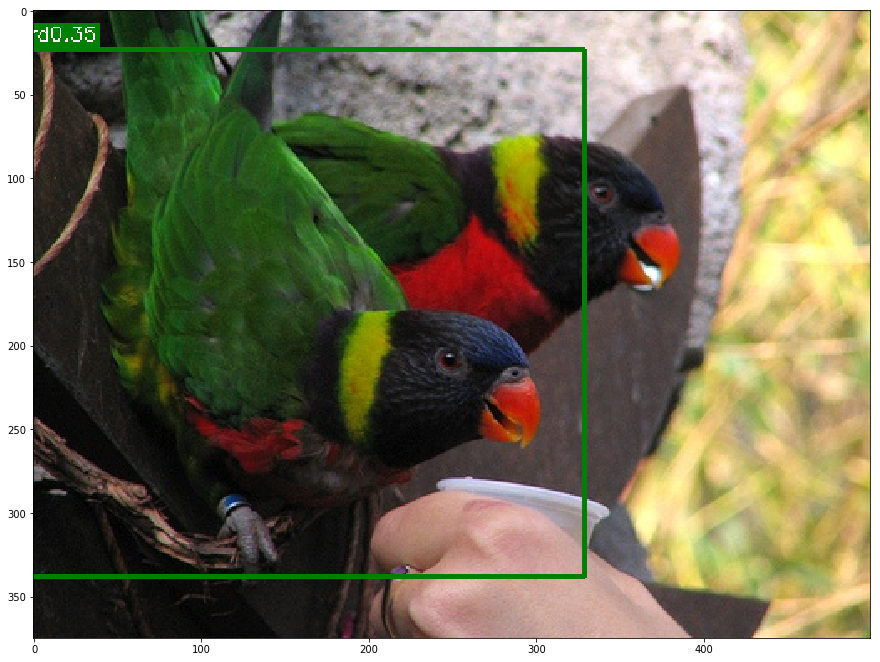

In [26]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [27]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:20<00:00, 61.56it/s]


---class aeroplane ap 0.5219431666198617---
---class bicycle ap 0.5531239051111997---
---class bird ap 0.4687586039012494---
---class boat ap 0.29974215858188114---
---class bottle ap 0.17845519373584734---
---class bus ap 0.6069752156819173---
---class car ap 0.6402728196694963---
---class cat ap 0.6659224839746425---
---class chair ap 0.28632598656343594---
---class cow ap 0.4631157860369395---
---class diningtable ap 0.33702565324480327---
---class dog ap 0.5798445290243366---
---class horse ap 0.6719423663676491---
---class motorbike ap 0.5579638123008808---
---class person ap 0.4989258659594752---
---class pottedplant ap 0.2093356809038186---
---class sheep ap 0.47632316107997574---
---class sofa ap 0.4530998925955493---
---class train ap 0.6474984791245608---
---class tvmonitor ap 0.46491123033716253---
---map 0.4790752995407342---


In [28]:
output_submission_csv('my_solution.csv', test_aps)